In [1]:
using GaussianProcesses
using Random
using LinearAlgebra
using Distributions
using Plots
using Optim
using StatsFuns

Forrás: 
http://krasserm.github.io/2020/11/04/gaussian-processes-classification/

# Bevezető 

A fajelterjedési modellek legtöbbje esetében azzal a problémával szembesülünk, hogy a modellezni kívánt fajről csak a jelenlét adatok állnak a rendelkezésünkre, míg hiány adatok nem (sok esetben nem tudjuk, hogy hol nem él az adott faj). Ezt pszeudo-hiány pontok véletlenszerű létrehozásával szokták ellensúlyozni. 

A mi esetünkben úgy választottunk meg két pettyes gőte alfajt, hogy azok elterjedése térben komplementer legyen. Azaz, ahol az egyik alfajt morfológiai és genentikai bélyegek alapján megtalálták, ott a másik alfaj nem fordult elő. Az erdélyi pettyes gőte (*Lissotriton vulgaris ampelensis*) kimondottan az Erdélyi-medencére jellemző, míg a pettyes gőte alap alfaja (*Lissotriton vulgaris vulgaris*) a Kárpátokon kívülre jellemző. 

Bizonyos élőlénycsoportok esetében területarányosan kevés adat áll rendelkezésünkre, mint például jelen esetben: 
- 411 jelenlét-pont az erdélyi pettyes gőte esetében; és
- 226 a pettyes gőte alap alfajának esetében 


Szeretnénk vizsgálni, hogy: 
1. A pszeudo-hiány pontok helyett használhatók-e a két komplementer elterjedést mutató alfaj jelenlét adatai egy bináris osztályozási probléma célváltozójaként?
2. Gauss-folyamatok által tanulható a fajok elterjedése bioklimatikai változók alapján?

A két pettyes gőte alfaj jelenlét pontjait tekintsük a bináris osztályozás célváltozójának. Lássuk el címkékkel a jelenlét adatokat: 
- Erdélyi pettyes gőte címke: 1
- Alap pettyes gőte alfaj címke: 0. 

A célváltozónk tehát két értéket vehet fel $Y \in \{0,1\}$ és *Y* Bernoulli eloszlást követ: 
$$p(Y=1|a) = \sigma(a)$$

$$ p(Y=0|a) = 1 - p(Y = 1|a),$$

ahol $\sigma(a)$ logisztikus szigmoid függvény, amely az $a \in \mathbb{R}$ argumentum logit értékeit alakítja át *0* és *1* közé.

Mindegyik Y értékhez tartozik egy $X \in \mathbb{R}^d$ érték is, ahol *d* a bioklimatikai változók száma.

## Próba adathalmaz létrehozása

Tételezzük fel, hogy két Pettyes gőte alfaj valamilyen eloszlást követ a térben. Az egyik alfaj kifejezetten Erdélyre jellemző és a Kárpátok vanulatára, míg a másik alfaj a kárpátokon kívül fordul elő és ezen elterjedések átfedése a lehető legkisebb (ökológiai háttérfolyamatoknak és fajképződésnek következtében). 

Az adathalmaz tartalmazzon összesen 200 megifgyelést. A próba adathalmaz esetén a biolimatikai változókat képviselje két változó, tehát $X \in \mathbb{R}^2$. 

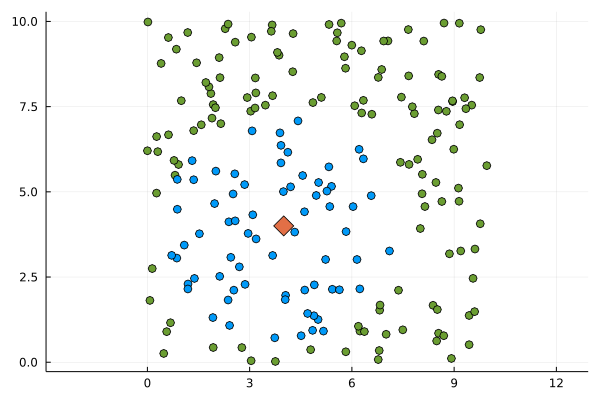

In [2]:
Random.seed!(154)

n_data = 200
dim = 2
cent_1 = [4;4]
rad_sq = 12
X_train = rand(n_data, dim)*10

z = X_train .- cent_1'
class_1 = map(z -> z ? 1 : 0, sum(z .^ 2, dims = 2) .< rad_sq);

Y_occurrence = [class_1[i] for i in 1:length(class_1)];

p = scatter(X_train[:, 1], X_train[:, 2], m=:o, labels=false, color = class_1)
scatter!(p, [cent_1[1]], [cent_1[2]], m=:d, ms = 10, labels = false, aspect_ratio=:equal)

# Gauss folyamatok

A Gauss-folyamat egy véletlenszerű folyamat, ahol minden $X \in \mathbb{R}^2$ egy $f(x)$ random változó származéka és az $ p(f(x_1)$...$f(x_N))$ random áltozók kapcsolt eloszlása normál: 

$$ p(f|X) = \mathcal{N}(f|\mu, K),\$$ 

ahol:

$\mu = 0$ és $K = k(X, X)$, ahol $k$ egy paraméteres kernel. 

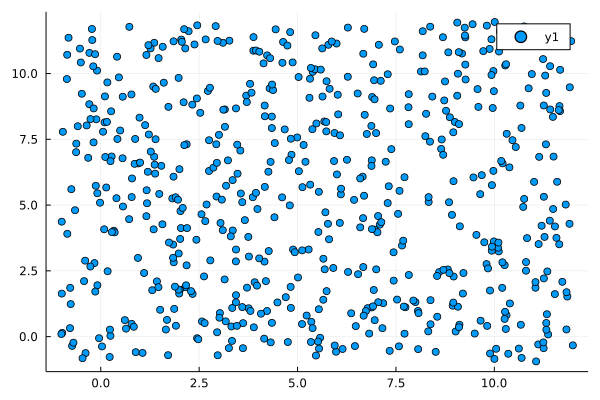

In [7]:
X1_ = rand(Uniform(-1, 12), 600)
X2_ = rand(Uniform(-1, 12), 600)

X2D = hcat(X1_, X2_);
scatter(X2D[:, 1], X2D[:, 2])

# Kernel függvény

Kernel függvénynek egy négyzetes exponenciális kernelt válaszottunk meg: 

$$k(X_1, X_2) = e^{- \frac{1}{2 l^2} D}, $$
ahol $l$ a hossúság skála paraméter *(length scale parameter)* és:
$$ D = X_1 + X_2 - 2 X_1 X_2^{T} $$


In [8]:
function kernel(X1, X2, theta)

    """
    Squared exponential kernel.

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).
        theta: Kernel parameters

    Returns:
        (m x n) matrix
    """
    
    sq_dist = sum(X1.^2, dims = 2) .+ sum(X2.^2, dims = 2)'.- 2 * X1 * X2'
    
    δ = - 0.5/theta[1]^2
    d = exp.(δ*sq_dist)
    
    Σ = theta[2] * d
    
    Σ = Σ + 0.000001*I # It gives Cholesky factorization error without this trick due to floating point precision**
    return(Σ)
end

kernel (generic function with 1 method)

In [5]:
# try the kernel

# theta contains the length parameter and a multiplicative constant

theta = [1.0, 1.0]

kernel(X_train, X_train, theta) # looks good

200×200 Matrix{Float64}:
 1.0          4.43646e-15  7.63378e-9   …  8.52697e-17  5.49627e-19
 4.43646e-15  1.0          0.0202482       0.858281     4.36313e-14
 7.63378e-9   0.0202482    1.0             0.00993827   7.46642e-8
 6.50396e-8   6.43672e-17  3.7021e-8       1.2942e-17   8.14885e-5
 1.16121e-8   0.0910978    0.549577        0.0345256    7.83027e-11
 3.35956e-12  3.75472e-15  2.2717e-7    …  2.23514e-15  0.0582815
 0.148667     6.69687e-11  4.42913e-5      3.71208e-12  3.69637e-12
 4.26912e-15  2.51857e-6   0.005352        4.29682e-6   0.0213723
 9.7238e-9    2.23705e-6   0.0515881       1.2093e-6    0.00133532
 0.256497     3.74716e-11  2.05248e-5      1.78126e-12  3.25941e-13
 0.0420504    3.53952e-8   0.00144277   …  2.66787e-9   7.11595e-12
 1.63269e-9   0.0194843    0.95397         0.0112096    2.66582e-7
 0.220346     5.8847e-10   9.66122e-6      2.04274e-11  1.1934e-17
 ⋮                                      ⋱               
 1.00833e-14  2.59111e-23  5.30747e-13     

In [66]:
K_a = kernel(X_train, X_train, theta)

200×200 Matrix{Float64}:
 1.0          4.43646e-15  7.63378e-9   …  8.52697e-17  5.49627e-19
 4.43646e-15  1.0          0.0202482       0.858281     4.36313e-14
 7.63378e-9   0.0202482    1.0             0.00993827   7.46642e-8
 6.50396e-8   6.43672e-17  3.7021e-8       1.2942e-17   8.14885e-5
 1.16121e-8   0.0910978    0.549577        0.0345256    7.83027e-11
 3.35956e-12  3.75472e-15  2.2717e-7    …  2.23514e-15  0.0582815
 0.148667     6.69687e-11  4.42913e-5      3.71208e-12  3.69637e-12
 4.26912e-15  2.51857e-6   0.005352        4.29682e-6   0.0213723
 9.7238e-9    2.23705e-6   0.0515881       1.2093e-6    0.00133532
 0.256497     3.74716e-11  2.05248e-5      1.78126e-12  3.25941e-13
 0.0420504    3.53952e-8   0.00144277   …  2.66787e-9   7.11595e-12
 1.63269e-9   0.0194843    0.95397         0.0112096    2.66582e-7
 0.220346     5.8847e-10   9.66122e-6      2.04274e-11  1.1934e-17
 ⋮                                      ⋱               
 1.00833e-14  2.59111e-23  5.30747e-13     

In [35]:
sigmoid(x) = 1/(1+exp(x))

function compute_W(x)
    W = sigmoid.(x) .* (1 .- sigmoid.(x))
    
    return LinearAlgebra.diagm(W)
end

x = Array(1:10)
compute_W(x)

10×10 Matrix{Float64}:
 0.196612  0.0       0.0        0.0        …  0.0          0.0
 0.0       0.104994  0.0        0.0           0.0          0.0
 0.0       0.0       0.0451767  0.0           0.0          0.0
 0.0       0.0       0.0        0.0176627     0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0        …  0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0           0.0          0.0
 0.0       0.0       0.0        0.0           0.000123379  0.0
 0.0       0.0       0.0        0.0           0.0          4.53958e-5

In [86]:
function posterior_hat(X, y, K_a, max_iter = 10, tol = 1e-9)
    """
    Computes the mode of posterior. 
    """
    
    a_hat = zeros(length(y))
    I_mat = LinearAlgebra.I(size(X)[1])
    
    for i in 1:max_iter
        W = compute_W(a_hat)
        Q_inv = LinearAlgebra.inv(I + W * K_a)
        
        a_hat_new = (K_a * Q_inv) * (y - sigmoid.(a_hat) + W * a_hat)
        a_hat_diff = abs.(a_hat_new .- a_hat)
        
        a_hat = a_hat_new
        
        if !any(a_hat_diff .> 1e-9)
           break
        end
    end
    return a_hat
end

posterior_hat (generic function with 3 methods)

In [88]:
posterior_hat(X_train, Y_occurrence, K_a);

200×200 Matrix{Float64}:
 0.000180399  0.0         0.0       …  0.0         0.0         0.0
 0.0          6.19685e-7  0.0          0.0         0.0         0.0
 0.0          0.0         0.245786     0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0       …  0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0       …  0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 0.0          0.0         0.0          0.0         0.0         0.0
 ⋮                                  ⋱                          
 0.0          0.0         0.0          0

# Kernel paraméter optimalizáció

A kernel $\theta$ paramétere optimalizálható a marginális log-likelihood által.

$$p(Y|\theta) \approx Y^T \hat{a} - \frac{1}{2} \hat{a}^T K_a^{-1} \hat{a} - 
    \frac{1}{2}log|K_a| - \frac{1}{2}log|W + K_a^{-1}| - \sum_{n=1}^{N} log(1+e^{\hat{a}_n})$$,
    
ahol $N$ a tanító halmaz mérete. 

In [140]:
function negative_loglik(X, y, theta)
 
    K_a = kernel(X,X, theta)
    K_a_inv = LinearAlgebra.inv(K_a) 
    
    a_hat = posterior_hat(X_train, y, K_a)
    W = compute_W(a_hat)

    comp1 = y' * a_hat
    comp2 = -0.5 * a_hat' * K_a_inv * a_hat
    comp3 = -0.5 * logdet(K_a)
    comp4 = -0.5*logdet(W + K_a_inv)
    comp5 = sum(log.(1 .+ exp.(a_hat)))
    ll = comp1 + comp2 + comp3 + comp4 + comp5
    
    return (-ll)
end

negative_loglik (generic function with 1 method)

In [141]:
negative_loglik(X_train, Y_occurrence, theta)

-231.13643119960977

In [ ]:
function optimize()
    
   f = ((theta1, theta2),) -> negative_loglik(X, y, (theta1, theta2))

initial_x = [2.0, 1.0]
lower = [1, 0.1]
upper = [3,4.0] 
    
end

In [142]:
f = ((theta1, theta2),) -> negative_loglik(X_train, Y_occurrence, (theta1, theta2))

#11 (generic function with 1 method)

In [143]:
initial_x = [2.0, 1.0]
lower = [1, 0.1]
upper = [3,4.0] 

2-element Vector{Float64}:
 3.0
 4.0

In [ ]:
inner_optimizer = LBFGS()
results = optimize(f, lower, upper, initial_x, Fminbox(inner_optimizer))
l_optim, sigma_f_optim = Optim.minimizer(results)